In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

Using TensorFlow backend.


## Load the train and test dataset and the UNET model with the appropriate string extension!

In [3]:
train_images = np.load("./augmented_data_20/images_train.npy").astype('float32')
train_labels = np.load("./augmented_data_20/labels_train.npy")

test_images = np.load("./augmented_data_20/images_test.npy").astype('float32')
test_labels = np.load("./augmented_data_20/labels_test.npy")

print("Original image shape: %s" % (train_images.shape,))
print("Original label shape: %s" % (train_labels.shape,))

string = '16F25Dr3WsreA3D'  # string indicating the set of parameters to load
print("UNET parameters selection: " + string)

U_net = tf.keras.models.load_model('U_net_' + string)  # load the UNET

file_path = "U_net_" + string + ".h5"  # file to save the weights
checkpoint = ModelCheckpoint(file_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

Original image shape: (13472, 256, 256)
Original label shape: (13472, 256, 256)
UNET parameters selection: 16F25Dr3WsreA3D


## Compute weights for each class

In [4]:
ct0=[]
ct1=[]
ct2=[]
for i in range(0, train_labels.shape[0]):
    img = train_labels[i,:,:]
    mask = np.zeros((img.shape[0], img.shape[1], 3))
    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==0))
    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==1))
    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==2))
    ct0.append(np.sum(mask[:,:,0]))
    ct1.append(np.sum(mask[:,:,1]))
    ct2.append(np.sum(mask[:,:,2]))
sum_all= sum(ct0)+sum(ct1)+sum(ct2)
wt0= 1-(sum(ct0)/sum_all)
wt1= 1-(sum(ct1)/sum_all)
wt2= 1-(sum(ct2)/sum_all)
print(wt0, wt1, wt2)

0.06419430096189083 0.9789436333536252 0.956862065684484


## Normalize the input images

In [5]:
def normalize(image):
    image = image - np.amin(image)
    image = image/np.amax(image)
    return image

print("Range of input values: %s" % {np.amin(train_images), np.amax(train_images)})

for i in range(train_images.shape[0]):
    train_images[i] = normalize(train_images[i])
for i in range(test_images.shape[0]):
    test_images[i] = normalize(test_images[i])
    
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

print("Normalized range of input values: %s" % {np.amin(train_images), np.amax(train_images)})
print("Normalized input image shape: %s" % (train_images.shape,))

Range of input values: {-128.0, 127.0}
Normalized range of input values: {0.0, 1.0}
Normalized input image shape: (13472, 256, 256, 1)


## Convert the training labels to categorical vectors

In [6]:
new_train_labels = np.reshape(train_labels, [train_labels.shape[0], train_labels.shape[1]*train_labels.shape[2]])
train_labels = new_train_labels
print("Vectorized new label shape: %s" % (train_labels.shape,))

Vectorized new label shape: (13472, 65536)


## Train the UNET

In [7]:
history = U_net.fit(train_images, train_labels, epochs = 5, validation_split = 0.2, verbose = 1, 
                    callbacks = callbacks_list, class_weight = [wt0, wt1, wt2])

Train on 10777 samples, validate on 2695 samples
Epoch 1/5
10777/10777 [==============================] - 3570s 331ms/sample - loss: 0.2420 - accuracy: 0.9363 - val_loss: 0.3774 - val_accuracy: 0.9336


C:\Users\geors\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/5
10777/10777 [==============================] - 3432s 318ms/sample - loss: 0.2002 - accuracy: 0.9363 - val_loss: 0.2875 - val_accuracy: 0.9336
Epoch 3/5
10777/10777 [==============================] - 3045s 283ms/sample - loss: 0.1869 - accuracy: 0.9366 - val_loss: 0.2943 - val_accuracy: 0.9331
Epoch 4/5
10777/10777 [==============================] - 3082s 286ms/sample - loss: 0.1796 - accuracy: 0.9381 - val_loss: 0.2004 - val_accuracy: 0.9367
Epoch 5/5
10777/10777 [==============================] - 3466s 322ms/sample - loss: 0.1729 - accuracy: 0.9418 - val_loss: 0.2475 - val_accuracy: 0.9361


## Get predicted labels

In [10]:
U_net.save_weights(file_path)
U_net.load_weights(file_path)
test_labels_pred = U_net.predict(test_images)

## Evaluate the U-net: Overall precision, Per-class precision, IoU

In [11]:
print("Shape of test labels: %s \nShape of predicted labels: %s" % (test_labels.shape, test_labels_pred.shape))
new_test_labels = np.reshape(test_labels, [test_labels.shape[0], test_labels.shape[1]*test_labels.shape[2]])
print("New test labels shape: %s " % (new_test_labels.shape,))

Shape of test labels: (3368, 256, 256) 
Shape of predicted labels: (3368, 65536, 3)
New test labels shape: (3368, 65536) 


In [12]:
test_labels_pred = np.argmax(test_labels_pred, axis=-1)
print("New predicted labels shape: %s " % (test_labels_pred.shape,))

New predicted labels shape: (3368, 65536) 


In [13]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='macro'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='macro'))
    return results
get_scores(new_test_labels, test_labels_pred)

C:\Users\geors\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.9383014216842108, 0.48006326957366735, 0.3628723778811387]

In [15]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    return results
get_scores(new_test_labels, test_labels_pred)

[0.9383014216842108, 0.9052931925460005, 0.8863170787246343]

## Plot outcome as Confusion Matrix

In [16]:
# reshape back to original dimensions
test_labels_pred_org = np.reshape(test_labels_pred, [test_labels_pred.shape[0], 256, 256])
test_labels_pred_org.shape

(3368, 256, 256)

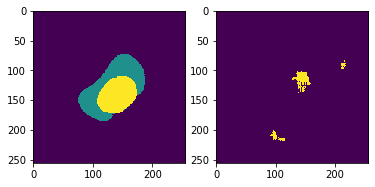

In [18]:
# plot an example of original label VS predicted label
ind = 2
plt.subplot(1,2,1)
plt.imshow(test_labels[ind])
plt.subplot(1,2,2)
plt.imshow(test_labels_pred_org[ind])

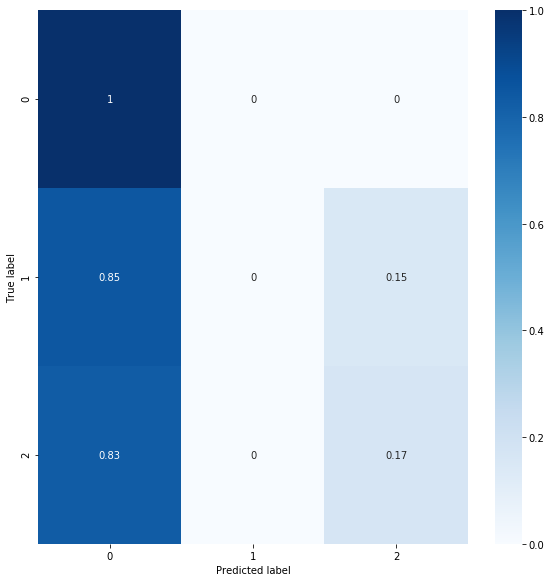

In [19]:
classes=[0,1,2]

con_mat = tf.math.confusion_matrix(labels=new_test_labels.flatten(), predictions=test_labels_pred.flatten()).numpy()

# Normalization of Confusion Matrix to the interpretation of which class is being misclassified.
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

# plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()